In [1]:
import time
import torch
from torch.utils.data import DataLoader, random_split
from torchtext.data import to_map_style_dataset

from reviews_dataset import reviews
from trainer import Trainer
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import pandas as pd

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
def train(trainer: Trainer, train_dataloader: DataLoader, valid_dataloader: DataLoader, EPOCHS = 10, LR = 5, BATCH_SIZE = 64):
    total_accu = None
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        trainer.train(train_dataloader, epoch)
        accu_val = trainer.evaluate(valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            trainer.scheduler.step()
        else:
            total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'valid accuracy {:8.3f} '.format(epoch,
                                               time.time() - epoch_start_time,
                                               accu_val))
        print('-' * 59)

def predict(trainer, dataloader: DataLoader):
    trainer.model.eval()
    preds = np.array([])
    labels = np.array([])

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = trainer.model(text, offsets)
            preds = np.concatenate([preds, (predicted_label.argmax(1) == label).cpu().numpy()])
            labels = np.concatenate([labels, label.cpu().numpy()])
    return preds, labels

def evaluate(trainer, dataloader):
    preds, y_test = predict(model, dataloader)
    accuracy = accuracy_score(preds, y_test)
    recall = recall_score(preds, y_test, average=None)
    cm = confusion_matrix(preds, y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','neu','pos'])
    f1 = f1_score(preds, y_test, average=None)
    disp.plot()

    return pd.DataFrame({'dataset':[dataset], 'accuracy':[np.round(accuracy, 3)], 'recall':[np.round(recall, 3)], 'f1_score':[np.round(f1,3)], 'training samples':[len(train_dataloader.dataset)]})

def getDatasets(dataset_path, BATCH_SIZE, trainer):
    train_iter, test_iter = reviews(root=dataset_path)
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)
    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    return train_dataloader, valid_dataloader, test_dataloader


In [5]:
ptm = pd.read_json(dataset_path, orient='records')

In [6]:
ptm

,text,label,score
0,"Doskonały stosunek jakości do ceny, poręczny, ...",pos,3
1,"Jest w porządku, choć za tą cenę mógłby trzyma...",pos,3
2,"kubek zgodny z opisem, wszystko w porządku",pos,3
3,Bardzo słabo pachną,neg,1
4,Produkt I klasy!,pos,3
...,...,...,...
10471,Doskonały,pos,3
10472,Moim zdaniem to podstawowa wersja tabletek teg...,neu,2
10473,Farba odpadła po umyciu w zmywarce,neu,2
10474,"Wytrzymały, estetyczny, solidnie wykonany. Bar...",pos,3


In [7]:
len(test_dataloader.dataset)

10476

In [8]:
len(train_dataloader.dataset)

9952

In [9]:
len(valid_dataloader.dataset)

524

In [6]:
datasets = os.listdir("../FinalDatasets/")

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '../FinalDatasets/'

In [4]:
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

dataset_path = 'FinalDatasets/complete_dataset_ptm.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = reviews(root=dataset_path, split='train')

trainer = Trainer(dataset, device, LR)
train_dataloader, valid_dataloader, test_dataloader = getDatasets(dataset_path, BATCH_SIZE, trainer)
# train(trainer, train_dataloader, valid_dataloader)


# train(trainer, dataset_path)

# reviews_labels = {1: "Negative",
#                     2: "Neutral",
#                     3: "Positive"}

# ex_text_str1 = "Super mega proszek, bardzo dobry"
# ex_text_str2 = "Totalny badziew szkoda pieniędzy, beznadziejny, porażka"
# ex_text_str3 = "Nie domywa ale ładnie pachnie. Zostają smugi"
# ex_text_str4 = "Nie rozpuszczają się, dobrze domywają, ładnie pachną, ale bardzo drogie"

# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str1)])
# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str2)])
# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str3)])
# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str4)])


In [50]:
predict(trainer, test_dataloader)

(array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 0., 2.]))

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'df_train' is not defined

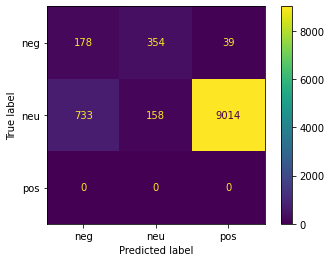

In [53]:
evaluate(trainer, test_dataloader)